### imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import emission.analysis.modelling.trip_model.run_model as eamtr
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import performance_eval
import data_wrangling


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
analysis.trip_model.conf.json not configured, falling back to sample, default configuration
storage not configured, falling back to sample, def

### load data

In [2]:
all_users = esta.TimeSeries.get_uuid_list()

confirmed_trip_df_map = {}
labeled_trip_df_map = {}
expanded_labeled_trip_df_map = {}
expanded_all_trip_df_map = {}
ct_entry={}
for u in all_users:
    ts = esta.TimeSeries.get_time_series(u)
    ct_df = ts.get_data_df("analysis/confirmed_trip")
    ct_entry[u]=eamtr._get_training_data(u,None)
    confirmed_trip_df_map[u] = ct_df
    labeled_trip_df_map[u] = esdtq.filter_labeled_trips(ct_df)
    expanded_labeled_trip_df_map[u] = esdtq.expand_userinputs(
        labeled_trip_df_map[u])
    expanded_all_trip_df_map[u] = esdtq.expand_userinputs(
        confirmed_trip_df_map[u])

found 796 training rows
found 518 training rows
found 2104 training rows
found 156 training rows
found 296 training rows
found 1625 training rows
found 18 training rows
found 626 training rows
found 2430 training rows
found 1060 training rows
found 1242 training rows
found 2390 training rows
found 480 training rows
found 455 training rows
found 453 training rows
found 1 training rows
found 84 training rows
found 2363 training rows
found 229 training rows
found 446 training rows
found 1346 training rows
found 159 training rows
found 14 training rows
found 233 training rows
found 1785 training rows
found 7 training rows
found 2523 training rows
found 1032 training rows
found 215 training rows
found 422 training rows
found 0 training rows
found 713 training rows
found 0 training rows
found 1218 training rows
found 0 training rows
found 176 training rows
found 0 training rows
found 32 training rows
found 0 training rows
found 0 training rows
found 1483 training rows
found 1865 training row

### run DBSCAN at varying distance thresholds

In [4]:
try:
    all_results_df = pd.read_csv('DBSCAN_vary_distance_threshold.csv')
except:
    param_grid = {
        'DBSCAN': {
            'SVM': [False],
            'min_samples': [1],
            'gamma': [0.05],
            'C': [1],
            'size_thresh': [1],
            'purity_thresh': [1],
        },
    }
    radii = [50, 100, 150, 200]

    all_results_df = performance_eval.run_eval_cluster_metrics(
        expanded_labeled_trip_df_map,
        ct_entry,
        clustering_way='destination',
        user_list=all_users,
        radii=radii,
        loc_type='end',
        algs=['DBSCAN'],
        param_grid=param_grid,
        n_iter=1,
        random_state=42)

    all_results_df = data_wrangling.expand_df_dict(all_results_df, 'params')
    all_results_df.to_csv('DBSCAN_vary_distance_threshold.csv', index=False)

testing DBSCAN
{'size_thresh': 1, 'purity_thresh': 1, 'min_samples': 1, 'gamma': 0.05, 'SVM': False, 'C': 1}
user 0a093cbd-b536-43af-b03d-293425e84c76 has no trips
user 0d0ae3a5-5641-4d13-8c52-a6040a203d24 has invalid dataframe, skipping
user 1157b533-888f-4ebd-a5b7-8431bdb153c4 has no trips
user 14103cda-12c9-4642-9741-29989d39e50d has invalid dataframe, skipping
user 19098644-b4ef-46a8-a7c7-b20e01e05ca3 has no trips
user 1ac2dbad-b3cb-4597-89af-f4de4340b5f0 has no trips
user 1f0f8091-a686-4437-bf7f-bab839c7f962 has no trips
user 2049efd4-211e-461f-85b3-b64b55c7b5b9 has no trips
user 21c78a1c-6df2-4097-b289-5a784610991b has no trips
user 22ac2a81-9d84-4c57-b152-7722f3307277 has invalid dataframe, skipping
user 2347dd52-fdbe-4a96-9b83-01c173dcf1fd has no trips
user 23e124ae-7e8c-49a0-ab29-fe6568d2d9e3 has no trips
user 23f48b0e-a372-4dbe-b8df-a481c04689b5 has no trips
user 2455a599-2b17-4239-a1c9-26a7de96d623 has invalid dataframe, skipping
user 2a957955-3954-4c98-8ce4-d0d5740057b1 has

### plot resulting cluster metrics

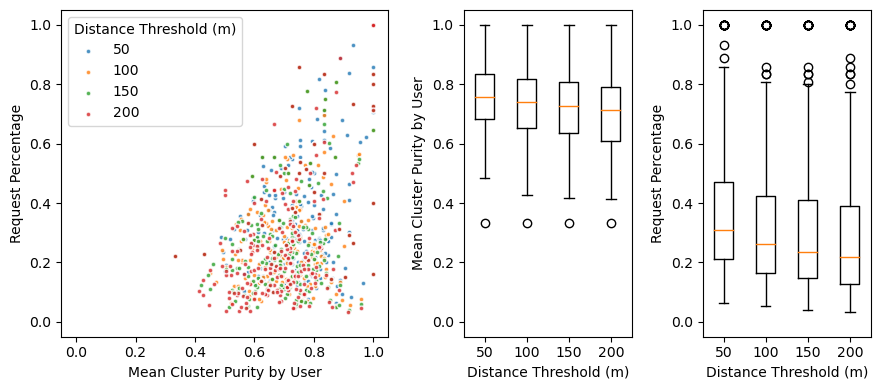

In [5]:
plt.style.use("default")
fig, axs = plt.subplots(1,
                        3,
                        figsize=(9, 4),
                        gridspec_kw={'width_ratios': [4, 2, 2]})

purities = []
req_pcts = []

radii = [50, 100, 150, 200]

for i in range(len(radii)):
    r = radii[i]
    results = all_results_df.loc[all_results_df['radius'] == r]
    purity = results.loc[:, 'purity']
    req_pct = results.loc[:, 'n_clusters'] / results.loc[:, 'n_trips']
    purities += [purity]
    req_pcts += [req_pct]
    axs[0].scatter(x=purity,
                   y=req_pct,
                   s=12,
                   color=plt.cm.tab10(i),
                   alpha=0.8,
                   edgecolors='white',
                   label=r)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend(title='Distance Threshold (m)')._legend_box.align = 'left'

axs[0].set_ylabel('Request Percentage')
axs[0].set_xlabel('Mean Cluster Purity by User')
axs[0].set_xlim(-0.05, 1.05)
axs[0].set_ylim(-0.05, 1.05)
axs[1].set_ylim(-0.05, 1.05)
axs[2].set_ylim(-0.05, 1.05)

axs[1].boxplot(purities)
axs[2].boxplot(req_pcts)

axs[1].set_xticklabels(radii)
axs[2].set_xticklabels(radii)

axs[1].set_ylabel('Mean Cluster Purity by User')
axs[2].set_ylabel('Request Percentage')

axs[1].set_xlabel('Distance Threshold (m)')
axs[2].set_xlabel('Distance Threshold (m)')

plt.tight_layout()
plt.show()


plot the same as above, but switch the XY axes for the boxplots

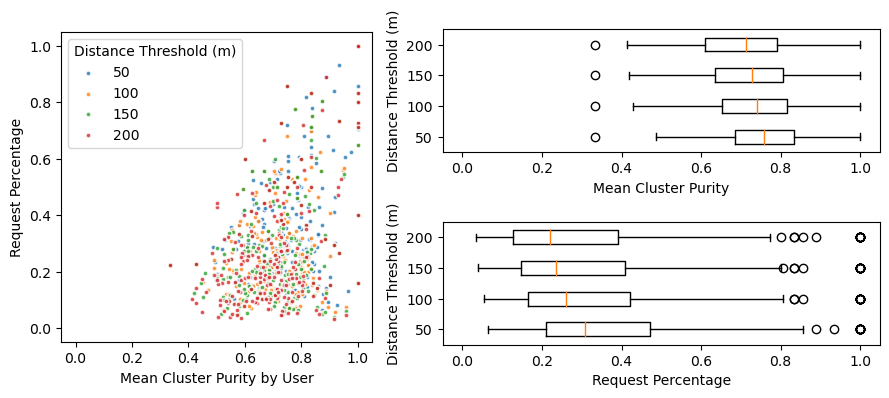

In [6]:
plt.style.use("default")
fig = plt.figure(figsize=(9, 4))

gs = GridSpec(2, 7)
axs = []
axs.append(plt.subplot(gs[:, 0:3]))
axs.append(plt.subplot(gs[0, 3:7]))
axs.append(plt.subplot(gs[1, 3:7]))

purities = []
req_pcts = []

radii = [50, 100, 150, 200]

for i in range(len(radii)):
    r = radii[i]
    results = all_results_df.loc[all_results_df['radius'] == r]
    purity = results.loc[:, 'purity']
    req_pct = results.loc[:, 'n_clusters'] / results.loc[:, 'n_trips']
    purities += [purity]
    req_pcts += [req_pct]
    axs[0].scatter(x=purity,
                   y=req_pct,
                   s=12,
                   color=plt.cm.tab10(i),
                   alpha=0.8,
                   edgecolors='white',
                   label=r)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend(title='Distance Threshold (m)')._legend_box.align = 'left'

axs[0].set_ylabel('Request Percentage')
axs[0].set_xlabel('Mean Cluster Purity by User')
axs[0].set_xlim(-0.05, 1.05)
axs[0].set_ylim(-0.05, 1.05)
axs[1].set_xlim(-0.05, 1.05)
axs[2].set_xlim(-0.05, 1.05)

axs[1].boxplot(purities, vert=False)
axs[2].boxplot(req_pcts, vert=False)

axs[1].set_yticklabels(radii)
axs[2].set_yticklabels(radii)

axs[1].set_xlabel('Mean Cluster Purity')
axs[2].set_xlabel('Request Percentage')

axs[1].set_ylabel('Distance Threshold (m)')
axs[2].set_ylabel('Distance Threshold (m)')

plt.tight_layout()
plt.show()


this time we only want to compare: 
* DBSCAN+SVM, 100m
* DBSCAN, 100m
* DBSCAN, 50m

first, we need to run the algorith for DBSCAN+SVM.

In [9]:
SVM_param_grid = {
    'DBSCAN': {
        'SVM': [True],
        'min_samples': [1],
        'gamma': [0.05],
        'C': [1],
        'size_thresh': [1],
        'purity_thresh': [1],
        # 'radii': [50, 100, 150]
    },
}
radii = [100]

SVM_results_df = performance_eval.run_eval_cluster_metrics(
    expanded_labeled_trip_df_map,
    ct_entry,
    clustering_way="destination",
    user_list=all_users,
    radii=radii,
    loc_type='end',
    algs=['DBSCAN'],
    param_grid=SVM_param_grid,
    n_iter=1,
    random_state=42)

SVM_results_df = data_wrangling.expand_df_dict(SVM_results_df, 'params')
combined_results_df = pd.concat([all_results_df, SVM_results_df],
                                ignore_index=True)


testing DBSCAN
{'size_thresh': 1, 'purity_thresh': 1, 'min_samples': 1, 'gamma': 0.05, 'SVM': True, 'C': 1}
user 0a093cbd-b536-43af-b03d-293425e84c76 has no trips
user 0d0ae3a5-5641-4d13-8c52-a6040a203d24 has invalid dataframe, skipping
user 1157b533-888f-4ebd-a5b7-8431bdb153c4 has no trips
user 14103cda-12c9-4642-9741-29989d39e50d has invalid dataframe, skipping
user 19098644-b4ef-46a8-a7c7-b20e01e05ca3 has no trips
user 1ac2dbad-b3cb-4597-89af-f4de4340b5f0 has no trips
user 1f0f8091-a686-4437-bf7f-bab839c7f962 has no trips
user 2049efd4-211e-461f-85b3-b64b55c7b5b9 has no trips
user 21c78a1c-6df2-4097-b289-5a784610991b has no trips
user 22ac2a81-9d84-4c57-b152-7722f3307277 has invalid dataframe, skipping
user 2347dd52-fdbe-4a96-9b83-01c173dcf1fd has no trips
user 23e124ae-7e8c-49a0-ab29-fe6568d2d9e3 has no trips
user 23f48b0e-a372-4dbe-b8df-a481c04689b5 has no trips
user 2455a599-2b17-4239-a1c9-26a7de96d623 has invalid dataframe, skipping
user 2a957955-3954-4c98-8ce4-d0d5740057b1 has 

now plot it:

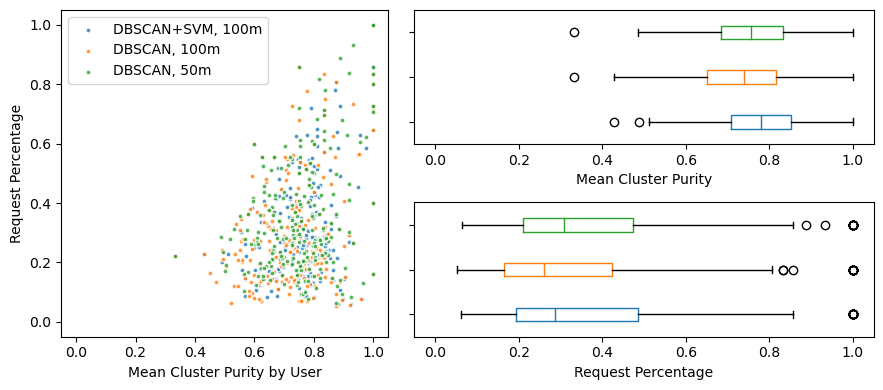

In [10]:
plt.style.use("default")
fig = plt.figure(figsize=(9, 4))

gs = GridSpec(2, 7)
axs = []
axs.append(plt.subplot(gs[:, 0:3]))
axs.append(plt.subplot(gs[0, 3:7]))
axs.append(plt.subplot(gs[1, 3:7]))

purities = []
req_pcts = []

radii = [50, 100]
conditions = [(100, True), (100, False), (50, False)] # (radius, SVM)

labels = ["DBSCAN+SVM, 100m", "DBSCAN, 100m", "DBSCAN, 50m"]

for i, c in enumerate(conditions):
    rad, svm = c
    results = combined_results_df.loc[(combined_results_df['radius'] == rad)
                                      & (combined_results_df['SVM'] == svm)]
    purity = results.loc[:, 'purity']
    req_pct = results.loc[:, 'n_clusters'] / results.loc[:, 'n_trips']
    purities += [purity]
    req_pcts += [req_pct]
    axs[0].scatter(x=purity,
                   y=req_pct,
                   s=12,
                   color=plt.cm.tab10(i),
                   alpha=0.8,
                   edgecolors='white',
                   label=labels[i])
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend()

axs[0].set_ylabel('Request Percentage')
axs[0].set_xlabel('Mean Cluster Purity by User')
axs[0].set_xlim(-0.05, 1.05)
axs[0].set_ylim(-0.05, 1.05)
axs[1].set_xlim(-0.05, 1.05)
axs[2].set_xlim(-0.05, 1.05)

bp_purity = axs[1].boxplot(purities, vert=False)
bp_reqpct = axs[2].boxplot(req_pcts, vert=False)

for element in ['boxes', 'fliers', 'means', 'medians']: 
    # ignore 'whiskers', 'caps'
    for i, (el_pur, el_rp) in enumerate(zip(bp_purity[element], bp_reqpct[element])):
        plt.setp(el_pur, color=plt.cm.tab10(i))
        plt.setp(el_rp, color=plt.cm.tab10(i))

axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

axs[1].set_xlabel('Mean Cluster Purity')
axs[2].set_xlabel('Request Percentage')

plt.tight_layout()
plt.show()

In [11]:
import scipy
import numpy as np

In [12]:
def func(x, a, b):
    return a * x + b

After curve fitting, parameters are [ 0.99613933 -0.38197375]
After curve fitting, parameters are [ 0.96443784 -0.37876348]
After curve fitting, parameters are [ 0.99284157 -0.40792127]
After curve fitting, parameters are [ 0.96282911 -0.3889081 ]


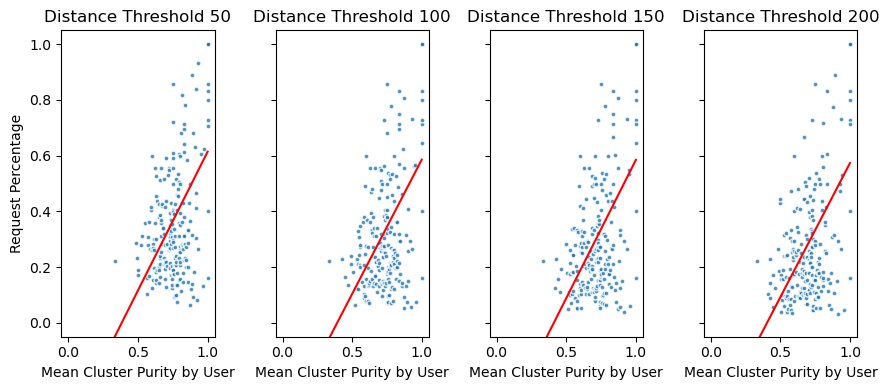

In [13]:
plt.style.use("default")
fig, axs = plt.subplots(1,
                        4,
                        figsize=(9, 4),
                        sharex=True,
                        sharey=True)

purities = []
req_pcts = []

radii = [50, 100, 150, 200]

for i in range(len(radii)):
    r = radii[i]
    results = all_results_df.loc[all_results_df['radius'] == r].copy()
    results['req_pct'] = results.loc[:, 'n_clusters'] / results.loc[:, 'n_trips']
    results.sort_values(by='purity', inplace=True)
    hom = results.loc[:, 'homogeneity']
    mod_hom = results.loc[:, 'modified_homogeneity']
    purity = results.loc[:, 'purity']
    req_pct = results.loc[:, 'req_pct']
    purities += [purity]
    req_pcts += [req_pct]
    popt, pcov = scipy.optimize.curve_fit(func, purity, req_pct)
    print("After curve fitting, parameters are %s" % popt)
    axs[i].scatter(x=purity,
                   y=req_pct,
                   s=12,
                   alpha=0.8,
                   edgecolors='white')
    axs[i].plot(purity, func(purity, *popt), "r-")
    axs[i].set_title("Distance Threshold %d" % r)
    axs[i].set_xlabel('Mean Cluster Purity by User')

axs[0].set_ylabel('Request Percentage')
axs[0].set_xlim(-0.05, 1.05)
axs[0].set_ylim(-0.05, 1.05)

# fig.suptitle('DBSCAN Cluster Quality Across All Users')
plt.tight_layout()
plt.show()


After curve fitting, parameters are [ 0.99613933 -0.38197375]
After curve fitting, parameters are [ 0.96443784 -0.37876348]
After curve fitting, parameters are [ 0.99284157 -0.40792127]
After curve fitting, parameters are [ 0.96282911 -0.3889081 ]


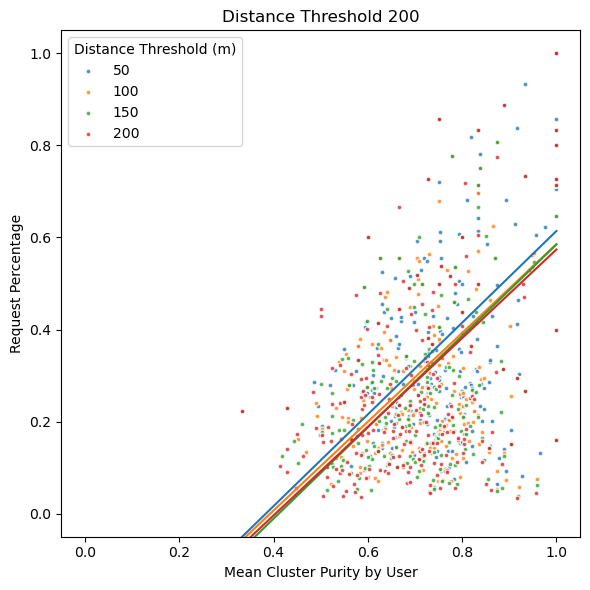

In [14]:
plt.style.use("default")
fig, axs = plt.subplots(1,
                        1,
                        figsize=(6, 6),
                        sharex=True,
                        sharey=True)

purities = []
req_pcts = []

radii = [50, 100, 150, 200]

for i in range(len(radii)):
    r = radii[i]
    results = all_results_df.loc[all_results_df['radius'] == r].copy()
    results['req_pct'] = results.loc[:, 'n_clusters'] / results.loc[:, 'n_trips']
    results.sort_values(by='purity', inplace=True)
    hom = results.loc[:, 'homogeneity']
    mod_hom = results.loc[:, 'modified_homogeneity']
    purity = results.loc[:, 'purity']
    req_pct = results.loc[:, 'req_pct']
    popt, pcov = scipy.optimize.curve_fit(func, purity, req_pct)
    print("After curve fitting, parameters are %s" % popt)
    axs.scatter(x=purity,
                   y=req_pct,
                   s=12,
                   alpha=0.8,
                   color=plt.cm.tab10(i),
                   edgecolors='white',
                   label=r)
    axs.plot(purity, func(purity, *popt), color=plt.cm.tab10(i))
    axs.set_title("Distance Threshold %d" % r)
    axs.set_xlabel('Mean Cluster Purity by User')

axs.set_ylabel('Request Percentage')
axs.set_xlim(-0.05, 1.05)
axs.set_ylim(-0.05, 1.05)
axs.legend(title='Distance Threshold (m)')._legend_box.align = 'left'

# fig.suptitle('DBSCAN Cluster Quality Across All Users')
plt.tight_layout()
plt.show()
